## NYC COVID-19 Cases & Population Health Status

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns; sns.set()
import geoplot

In [2]:
nyc_population =  pd.read_csv("data/uhf_population2010.csv")

nyc_population = nyc_population[['United Hospital Fund (UHF 42) neighborhood, 2009', 'Borough', 'Total population, 2010']]

nyc_population.rename(columns = {'United Hospital Fund (UHF 42) neighborhood, 2009': 'neighborhood',
                                'Borough': 'borough',
                                'Total population, 2010': 'population'}, inplace = True)
nyc_population.head()

,neighborhood,borough,population
0,Kingsbridge - Riverdale,Bronx,94095
1,Northeast Bronx,Bronx,190315
2,Fordham - Bronx Pk,Bronx,250249
3,Pelham - Throgs Neck,Bronx,297059
4,Crotona-Tremont,Bronx,206630


In [3]:
test_by_zip = pd.read_csv("data/tests-by-zcta.csv", dtype= {'MODZCTA': str} )

test_by_zip = test_by_zip[1:]
test_by_zip.reset_index(drop = True, inplace = True)

test_by_zip.head()

,MODZCTA,Positive,Total,zcta_cum.perc_pos
0,10001,321,1130,28.41
1,10002,931,2457,37.89
2,10003,414,1549,26.73
3,10004,28,108,25.93
4,10005,54,256,21.09


In [4]:
uhf42_zipcodes = pd.read_csv("data/uhf42_zipcodes.csv")

uhf42_zipcodes['uhf42_neigh'] = uhf42_zipcodes['Neighborhood'].str.strip()

uhf42_zipcodes.head()

,Borough,Neighborhood,ZIP Codes,uhf42_neigh
0,Bronx,Fordham - Bronx Pk,"10458, 10467, 10468",Fordham - Bronx Pk
1,Bronx,Kingsbridge - Riverdale,"10463, 10471",Kingsbridge - Riverdale
2,Bronx,Northeast Bronx,"10466, 10469, 10470, 10475",Northeast Bronx
3,Bronx,Pelham - Throgs Neck,"10461, 10462, 10464, 10465, 10472, 10473",Pelham - Throgs Neck
4,Bronx,Hunts Point - Mott Haven,"10454, 10455, 10459, 10474",Hunts Point - Mott Haven


In [5]:
uhf34_zipcodes = pd.read_csv("data/uhf34_zipcodes.csv")

uhf34_zipcodes['uhf34_neigh'] = uhf34_zipcodes['Neighborhood'].str.strip()

uhf34_zipcodes.head()

,Borough,Neighborhood,ZIP Codes,uhf34_neigh
0,Bronx,Fordham - Bronx Pk,"10458, 10467, 10468",Fordham - Bronx Pk
1,NaN,Kingsbridge - Riverdale,"10463, 10471",Kingsbridge - Riverdale
2,NaN,Northeast Bronx,"10466, 10469, 10470, 10475",Northeast Bronx
3,NaN,Pelham - Throgs Neck,"10461, 10462, 10464, 10465, 10472, 10473",Pelham - Throgs Neck
4,NaN,South Bronx,"10451, 10452, 10453, 10454, 10455, 10456, 1045...",South Bronx


In [6]:
# MODZCTA_neighborhood = pd.concat([pd.Series(row['Neighborhood'], row['ZIP Codes'].split(',')) for _, row in uhf34_zipcodes.iterrows()]).reset_index()

# MODZCTA_neighborhood.rename(columns = {'index': 'zipcode', 0: 'neighborhood'}, inplace = True)

# MODZCTA_neighborhood.head()

In [7]:
#Mapping zipcodes to their  neighborhood

def uhf34zip_mapping(zipcode):
    neigh = uhf34_zipcodes['Neighborhood'][uhf34_zipcodes["ZIP Codes"].str.contains(zipcode)]
    return neigh.values
    
def uhf42zip_mapping(zipcode):
    neigh = uhf42_zipcodes['Neighborhood'][uhf42_zipcodes["ZIP Codes"].str.contains(zipcode)]
    return neigh.values
        
test_by_zip['MODZCTA'] = test_by_zip['MODZCTA'].str.strip()

test_by_zip['uhf34_neigh'] = test_by_zip['MODZCTA'].apply(uhf34zip_mapping)
test_by_zip['uhf42_neigh'] = test_by_zip['MODZCTA'].apply(uhf42zip_mapping)


test_by_zip['uhf34_neigh'] = test_by_zip['uhf34_neigh'].apply(lambda x: str(x).replace("['","").replace("']",""))
test_by_zip['uhf42_neigh'] = test_by_zip['uhf42_neigh'].apply(lambda x: str(x).replace("['","").replace("']",""))

test_by_zip.head()

,MODZCTA,Positive,Total,zcta_cum.perc_pos,uhf34_neigh,uhf42_neigh
0,10001,321,1130,28.41,Chelsea-Village,Chelsea-Clinton
1,10002,931,2457,37.89,Union Square-Lower Manhattan,Union Square - Lower East Side
2,10003,414,1549,26.73,Union Square-Lower Manhattan,Union Square - Lower East Side
3,10004,28,108,25.93,Union Square-Lower Manhattan,Lower Manhattan
4,10005,54,256,21.09,Union Square-Lower Manhattan,Lower Manhattan


Zip code treatment:

In [8]:
test_by_zip[test_by_zip['uhf34_neigh'] == '[]']

,MODZCTA,Positive,Total,zcta_cum.perc_pos,uhf34_neigh,uhf42_neigh
79,10474,301,725,41.52,[],Hunts Point - Mott Haven
124,11238,692,1887,36.67,[],Bedford Stuyvesant - Crown Heights
147,11378,675,1741,38.77,[],West Queens


In [9]:
test_by_zip.iloc[79,4] = 'South Bronx'
test_by_zip.iloc[124,4] = 'Bedford Stuyvesant - Crown Heights'
test_by_zip.iloc[147,4] = 'West Queens'

In [10]:
test_by_zip[test_by_zip['uhf42_neigh'] == '[]']

,MODZCTA,Positive,Total,zcta_cum.perc_pos,uhf34_neigh,uhf42_neigh
38,10065,303,1341,22.60,Upper East Side-Gramercy,[]
39,10069,49,198,24.75,Upper West Side,[]
40,10075,348,1217,28.59,Upper East Side-Gramercy,[]
43,10282,64,197,32.49,Union Square-Lower Manhattan,[]


In [11]:
test_by_zip.iloc[38,5] = 'Upper East Side'
test_by_zip.iloc[39,5] = 'Upper West Side'
test_by_zip.iloc[40,5] = 'Upper East Side'
test_by_zip.iloc[43,5] = 'Union Square - Lower East Side'

In [12]:
#MODZCTA and Neighborhoods for mapping later

MODZCTA_neighbohood = test_by_zip[['MODZCTA', 'uhf34_neigh', 'uhf42_neigh']]

MODZCTA_neighbohood.head()

,MODZCTA,uhf34_neigh,uhf42_neigh
0,10001,Chelsea-Village,Chelsea-Clinton
1,10002,Union Square-Lower Manhattan,Union Square - Lower East Side
2,10003,Union Square-Lower Manhattan,Union Square - Lower East Side
3,10004,Union Square-Lower Manhattan,Lower Manhattan
4,10005,Union Square-Lower Manhattan,Lower Manhattan


In [13]:
case_per_neighborhood = pd.DataFrame(test_by_zip.groupby(['uhf34_neigh','uhf42_neigh']).sum()).reset_index()

case_per_neighborhood['positive_rate'] = np.round(case_per_neighborhood['Positive']/case_per_neighborhood['Total']*100,2)

case_per_neighborhood = case_per_neighborhood[['uhf34_neigh','uhf42_neigh', 'positive_rate', 'Total']]

case_per_neighborhood.head()

,uhf34_neigh,uhf42_neigh,positive_rate,Total
0,Bayside Little Neck-Fresh Meadows,Bayside - Little Neck,35.44,3488
1,Bayside Little Neck-Fresh Meadows,Fresh Meadows,39.06,5277
2,Bedford Stuyvesant - Crown Heights,Bedford Stuyvesant - Crown Heights,39.09,13795
3,Bensonhurst - Bay Ridge,Bensonhurst - Bay Ridge,37.38,8079
4,Borough Park,Borough Park,38.58,20878


In [14]:
def merge_df(df1, df2, left_on, right_on):
    
    return df1.merge(df2,
                     left_on =left_on,
                     right_on = right_on).drop(columns=[right_on])

In [15]:
#Merging population data

case_per_neighborhood = merge_df(case_per_neighborhood, nyc_population[['neighborhood','borough', 'population']],
                                                     left_on = 'uhf42_neigh',
                                                     right_on='neighborhood')

case_per_neighborhood.rename(columns={"Neighborhood": "neighborhood", 
                                      "Total": "total_test"}, inplace= True)

case_per_neighborhood['test_per_capita'] = np.round(case_per_neighborhood['total_test']/ case_per_neighborhood['population'],
                                                    3)

case_per_neighborhood = case_per_neighborhood[['borough', 
                                               'uhf34_neigh',
                                               'uhf42_neigh', 
                                               'population', 
                                               'positive_rate', 
                                               'test_per_capita']]


case_per_neighborhood.head()

,borough,uhf34_neigh,uhf42_neigh,population,positive_rate,test_per_capita
0,Queens,Bayside Little Neck-Fresh Meadows,Bayside - Little Neck,87423,35.44,0.040
1,Queens,Bayside Little Neck-Fresh Meadows,Fresh Meadows,95537,39.06,0.055
2,Brooklyn,Bedford Stuyvesant - Crown Heights,Bedford Stuyvesant - Crown Heights,316269,39.09,0.044
3,Brooklyn,Bensonhurst - Bay Ridge,Bensonhurst - Bay Ridge,201541,37.38,0.040
4,Brooklyn,Borough Park,Borough Park,322563,38.58,0.065


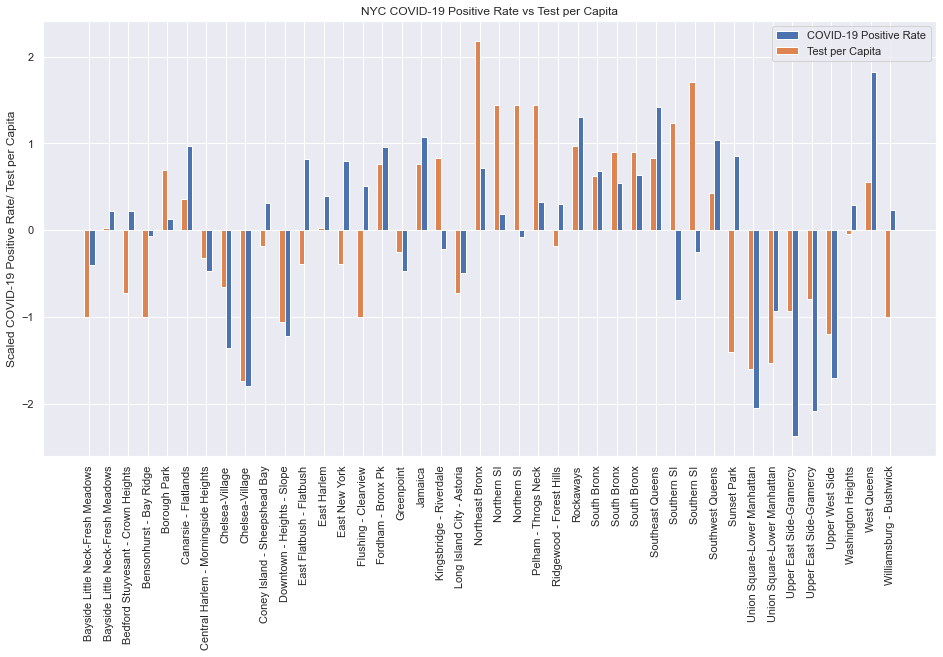

In [16]:
labels = case_per_neighborhood['uhf34_neigh'] #UHF34 Neighborhoods

x = np.arange(len(labels))  # the label locations
width = 0.275  # the width of the bars


scaled_positive_rate = scale(case_per_neighborhood['positive_rate'])
scaled_test_per_capita = scale(case_per_neighborhood['test_per_capita'])

fig, ax = plt.subplots(figsize=(16, 8))
rects1 = ax.bar(x + width/2, scaled_positive_rate, width, label='COVID-19 Positive Rate')
rects2 = ax.bar(x - width/2, scaled_test_per_capita, width, label='Test per Capita')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scaled COVID-19 Positive Rate/ Test per Capita')
ax.set_title('NYC COVID-19 Positive Rate vs Test per Capita')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(rotation=90)

ax.legend()

plt.show()

The graph shows that, by looking for different signs in the scaled values of positive case rate and test per capita, we can guess that some neighborhoods are undertested (e.g. Crown Heights, East Flatbush) or overtested (e.g.  Staten Island).

In [17]:
obesity = pd.read_csv("data/overweight_obese.csv")

obesity.iloc[:,0] = obesity.copy().iloc[:,0].str.strip()

obesity.head()

,Geography,Indicator Name,Number,Percent
0,New York City,Overweight or Obese Adults,"3,692,000",57.4
1,Bronx,Overweight or Obese Adults,"720,000",69.3
2,Brooklyn,Overweight or Obese Adults,"1,132,000",58.2
3,Manhattan,Overweight or Obese Adults,"582,000",44.4
4,Queens,Overweight or Obese Adults,"1,037,000",58.2


In [18]:
case_per_neighborhood = merge_df(case_per_neighborhood, obesity[['Geography','Percent']],
                                                     left_on = 'uhf34_neigh',
                                                     right_on='Geography')

case_per_neighborhood.rename(columns = {'Percent': "obesity_percent"}, inplace= True)

case_per_neighborhood.head()

,borough,uhf34_neigh,uhf42_neigh,population,positive_rate,test_per_capita,obesity_percent
0,Queens,Bayside Little Neck-Fresh Meadows,Bayside - Little Neck,87423,35.44,0.040,53.4
1,Queens,Bayside Little Neck-Fresh Meadows,Fresh Meadows,95537,39.06,0.055,53.4
2,Brooklyn,Bedford Stuyvesant - Crown Heights,Bedford Stuyvesant - Crown Heights,316269,39.09,0.044,67.2
3,Brooklyn,Bensonhurst - Bay Ridge,Bensonhurst - Bay Ridge,201541,37.38,0.040,50.3
4,Brooklyn,Borough Park,Borough Park,322563,38.58,0.065,56.3


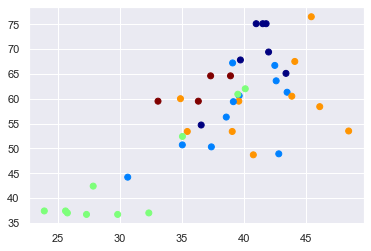

In [19]:
plt.scatter(case_per_neighborhood['positive_rate'],case_per_neighborhood['obesity_percent'],
            c= case_per_neighborhood['borough'].astype('category').cat.codes, 
            cmap = 'jet')
plt.show()

In [20]:
np.corrcoef(case_per_neighborhood['positive_rate'],case_per_neighborhood['obesity_percent'])

array([[1.       , 0.7580165],
       [0.7580165, 1.       ]])

There is some strong positive correlation between obesity rate and postive COVID cases across neighborhoods.

In [21]:
excercise = pd.read_csv("data/exercise_2017.csv")

excercise.iloc[:,2] = excercise.copy().iloc[:,2].str.strip()

excercise.head()

,GeoTypeName,Borough,Geography,Geography ID,Number,Percent
0,Citywide,New York City,New York City,1,"4,893,000",74.5
1,Borough,Bronx,Bronx,1,"741,000",70.0
2,Borough,Brooklyn,Brooklyn,2,"1,421,000",71.8
3,Borough,Manhattan,Manhattan,3,"1,115,000",83.5
4,Borough,Queens,Queens,4,"1,355,000",74.0


In [22]:
case_per_neighborhood = merge_df(case_per_neighborhood, excercise[['Geography','Percent']], 
                                 left_on = 'uhf34_neigh',
                                 right_on='Geography')

case_per_neighborhood.rename(columns = {'Percent': "excercise_percent"}, inplace= True)

case_per_neighborhood.head()

,borough,uhf34_neigh,uhf42_neigh,population,positive_rate,test_per_capita,obesity_percent,excercise_percent
0,Queens,Bayside Little Neck-Fresh Meadows,Bayside - Little Neck,87423,35.44,0.040,53.4,73.4
1,Queens,Bayside Little Neck-Fresh Meadows,Fresh Meadows,95537,39.06,0.055,53.4,73.4
2,Brooklyn,Bedford Stuyvesant - Crown Heights,Bedford Stuyvesant - Crown Heights,316269,39.09,0.044,67.2,71.4
3,Brooklyn,Bensonhurst - Bay Ridge,Bensonhurst - Bay Ridge,201541,37.38,0.040,50.3,69.5
4,Brooklyn,Borough Park,Borough Park,322563,38.58,0.065,56.3,65.2


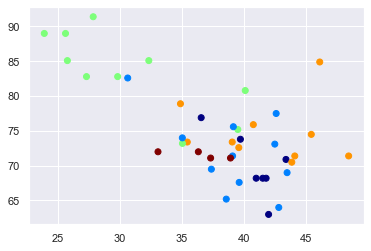

In [23]:
plt.scatter(case_per_neighborhood['positive_rate'],case_per_neighborhood['excercise_percent'],
            c= case_per_neighborhood['borough'].astype('category').cat.codes, 
            cmap = 'jet')
plt.show()

In [24]:
np.corrcoef(case_per_neighborhood['positive_rate'],case_per_neighborhood['excercise_percent'])

array([[ 1.        , -0.68219664],
       [-0.68219664,  1.        ]])

There is some medium-strong negative correlation between excercise rate and postive COVID cases across neighborhoods.

In [25]:
copd = pd.read_csv("data/copd_2016.csv")

copd.iloc[:,1] = copd.copy().iloc[:,1].str.strip()

copd.head()

,Borough,Geography,Indicator Name,"Age-Adjusted Rate (per 10,000 residents)","Estimated Annual Rate (per 10,000 residents)",Number
0,Bronx,Fordham - Bronx Pk,Chronic Obstructive Pulmonary Disease Hospita...,51.3,45.5,600
1,Bronx,Kingsbridge - Riverdale,Chronic Obstructive Pulmonary Disease Hospita...,37.5,33.8,546
2,Bronx,Northeast Bronx,Chronic Obstructive Pulmonary Disease Hospita...,54.2,52.1,707
3,Bronx,Pelham - Throgs Neck,Chronic Obstructive Pulmonary Disease Hospita...,56.9,53.5,467
4,Bronx,Hunts Point - Mott Haven,Chronic Obstructive Pulmonary Disease Hospita...,17.9,22.3,148


In [26]:
case_per_neighborhood = merge_df(case_per_neighborhood, copd[['Geography','Estimated Annual Rate (per 10,000 residents)']], 
                                 left_on = 'uhf42_neigh',
                                 right_on='Geography')

case_per_neighborhood.rename(columns = {'Estimated Annual Rate (per 10,000 residents)': "copd_rate"}, inplace= True)

case_per_neighborhood.head()

,borough,uhf34_neigh,uhf42_neigh,population,positive_rate,test_per_capita,obesity_percent,excercise_percent,copd_rate
0,Queens,Bayside Little Neck-Fresh Meadows,Bayside - Little Neck,87423,35.44,0.040,53.4,73.4,14.4
1,Queens,Bayside Little Neck-Fresh Meadows,Fresh Meadows,95537,39.06,0.055,53.4,73.4,14.5
2,Brooklyn,Bedford Stuyvesant - Crown Heights,Bedford Stuyvesant - Crown Heights,316269,39.09,0.044,67.2,71.4,27.7
3,Brooklyn,Bensonhurst - Bay Ridge,Bensonhurst - Bay Ridge,201541,37.38,0.040,50.3,69.5,38.3
4,Brooklyn,Borough Park,Borough Park,322563,38.58,0.065,56.3,65.2,16.9


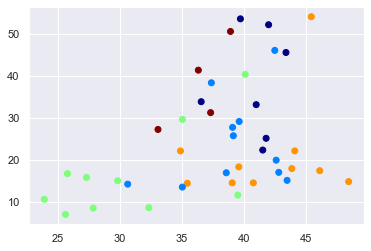

In [27]:
plt.scatter(case_per_neighborhood['positive_rate'],case_per_neighborhood['copd_rate'],
            c= case_per_neighborhood['borough'].astype('category').cat.codes, 
            cmap = 'jet')
plt.show()

In [28]:
np.corrcoef(case_per_neighborhood['positive_rate'],case_per_neighborhood['copd_rate'])

array([[1.        , 0.39174731],
       [0.39174731, 1.        ]])

There is no strong correlation between COPD rate and positive case rate.

In [29]:
smoking = pd.read_csv("data/Cigarette Smoking among Adults.csv")

smoking.iloc[:,3] = smoking.copy().iloc[:,3].str.strip()

smoking.head()

,Year,GeoTypeName,Borough,Geography,Geography ID,Indicator Name,Number,Percent,Notes Number,Notes Percent
0,2017,Citywide,New York City,New York City,1,Cigarette Smoking among Adults,"886,000",13.5,NaN,NaN
1,2017,Borough,Bronx,Bronx,1,Cigarette Smoking among Adults,"145,000",13.7,NaN,NaN
2,2017,Borough,Brooklyn,Brooklyn,2,Cigarette Smoking among Adults,"270,000",13.7,NaN,NaN
3,2017,Borough,Manhattan,Manhattan,3,Cigarette Smoking among Adults,"161,000",12.0,NaN,NaN
4,2017,Borough,Queens,Queens,4,Cigarette Smoking among Adults,"224,000",12.4,NaN,NaN


In [30]:
case_per_neighborhood = merge_df(case_per_neighborhood, smoking[['Geography','Percent']], 
                                 left_on = 'uhf34_neigh',
                                 right_on='Geography')

case_per_neighborhood.rename(columns = {'Percent': "smoking_percent"}, inplace= True)

case_per_neighborhood.head()

,borough,uhf34_neigh,uhf42_neigh,population,positive_rate,test_per_capita,obesity_percent,excercise_percent,copd_rate,smoking_percent
0,Queens,Bayside Little Neck-Fresh Meadows,Bayside - Little Neck,87423,35.44,0.040,53.4,73.4,14.4,11.2
1,Queens,Bayside Little Neck-Fresh Meadows,Fresh Meadows,95537,39.06,0.055,53.4,73.4,14.5,11.2
2,Brooklyn,Bedford Stuyvesant - Crown Heights,Bedford Stuyvesant - Crown Heights,316269,39.09,0.044,67.2,71.4,27.7,18.9
3,Brooklyn,Bensonhurst - Bay Ridge,Bensonhurst - Bay Ridge,201541,37.38,0.040,50.3,69.5,38.3,11.7
4,Brooklyn,Borough Park,Borough Park,322563,38.58,0.065,56.3,65.2,16.9,9.8


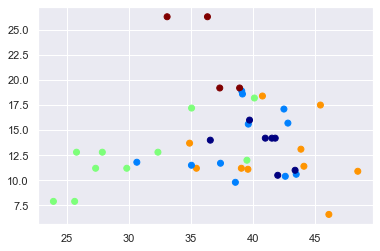

In [31]:
plt.scatter(case_per_neighborhood['positive_rate'],case_per_neighborhood['smoking_percent'],
            c= case_per_neighborhood['borough'].astype('category').cat.codes, 
            cmap = 'jet')
plt.show()

In [32]:
np.corrcoef(case_per_neighborhood['positive_rate'],case_per_neighborhood['smoking_percent'])

array([[1.        , 0.08370658],
       [0.08370658, 1.        ]])

There is no correlation at all between smoking and positive cases.

In [33]:
drinking = pd.read_csv("data/Adults Who Binge Drink.csv")

drinking.iloc[:,3] = drinking.copy().iloc[:,3].str.strip()

drinking.head()

,Year,GeoTypeName,Borough,Geography,Geography ID,Indicator Name,Number,Percent,Notes Number,Notes Percent
0,2017,Citywide,New York City,New York City,1,Adults Who Binge Drink,"1,126,000",17.4,NaN,NaN
1,2017,Borough,Bronx,Bronx,1,Adults Who Binge Drink,"145,000",14.0,NaN,NaN
2,2017,Borough,Brooklyn,Brooklyn,2,Adults Who Binge Drink,"307,000",15.7,NaN,NaN
3,2017,Borough,Manhattan,Manhattan,3,Adults Who Binge Drink,"340,000",25.6,NaN,NaN
4,2017,Borough,Queens,Queens,4,Adults Who Binge Drink,"271,000",15.1,NaN,NaN


In [34]:
case_per_neighborhood = merge_df(case_per_neighborhood, drinking[['Geography','Percent']], 
                                 left_on = 'uhf34_neigh',
                                 right_on='Geography')

case_per_neighborhood.rename(columns = {'Percent': "drinking_percent"}, inplace= True)

case_per_neighborhood.head()

,borough,uhf34_neigh,uhf42_neigh,population,positive_rate,test_per_capita,obesity_percent,excercise_percent,copd_rate,smoking_percent,drinking_percent
0,Queens,Bayside Little Neck-Fresh Meadows,Bayside - Little Neck,87423,35.44,0.040,53.4,73.4,14.4,11.2,11.7
1,Queens,Bayside Little Neck-Fresh Meadows,Fresh Meadows,95537,39.06,0.055,53.4,73.4,14.5,11.2,11.7
2,Brooklyn,Bedford Stuyvesant - Crown Heights,Bedford Stuyvesant - Crown Heights,316269,39.09,0.044,67.2,71.4,27.7,18.9,16.6
3,Brooklyn,Bensonhurst - Bay Ridge,Bensonhurst - Bay Ridge,201541,37.38,0.040,50.3,69.5,38.3,11.7,15.4
4,Brooklyn,Borough Park,Borough Park,322563,38.58,0.065,56.3,65.2,16.9,9.8,9.5


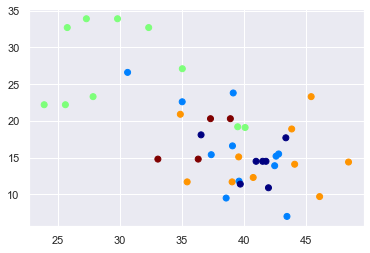

In [35]:
plt.scatter(case_per_neighborhood['positive_rate'],case_per_neighborhood['drinking_percent'],
            c= case_per_neighborhood['borough'].astype('category').cat.codes, 
            cmap = 'jet')
plt.show()

In [36]:
np.corrcoef(case_per_neighborhood['positive_rate'],case_per_neighborhood['drinking_percent'])

array([[ 1.        , -0.66361091],
       [-0.66361091,  1.        ]])

Semi-strong correlation between alcoholic drinking and positive cases.

In [37]:
pca = PCA(n_components=3)

In [38]:
neighborhoods = case_per_neighborhood.iloc[:,0:3]
metrics = case_per_neighborhood.iloc[:,6:]

In [39]:
pca_transformed = pca.fit_transform(metrics)

print(pca_transformed)

[[ -8.20700823   9.44777112   4.14353764]
 [ -8.13592548   9.38356635   4.1642124 ]
 [  9.9343859    4.36777006  -3.6265508 ]
 [  7.30833042  -7.86402541  11.43345641]
 [ -2.08546757  13.24518327   8.18784267]
 [ -0.82704037  16.48953541   3.66948222]
 [ -0.47360386  -9.18251721   0.57383685]
 [-25.06769606 -12.85109771  -0.37868455]
 [-24.49903408 -13.3647359   -0.2132865 ]
 [  8.67214011   4.65103963   5.41368941]
 [-19.49453284  -5.30390109  -1.89698267]
 [ -0.16983265   7.3835118   -5.35210109]
 [ 12.52677433 -10.46687469  -3.78893414]
 [ 22.52156865  -6.6132799    0.90005471]
 [-10.94985476   5.26120561   5.58940536]
 [ 20.33069346  -7.43994493   1.25742178]
 [-12.87669275   3.07160435   0.16929378]
 [  5.79211142  10.25375562  -3.70692841]
 [  4.35986489  -7.20161951   2.31185775]
 [ -1.96721468   0.60811622  -6.03663829]
 [ 31.18576205  -3.53711446   7.2703009 ]
 [ 23.93013411 -13.23294918   1.18480153]
 [ 10.21116384  -0.84142791  -2.80542644]
 [ 28.71016099  -9.78517921   2.56

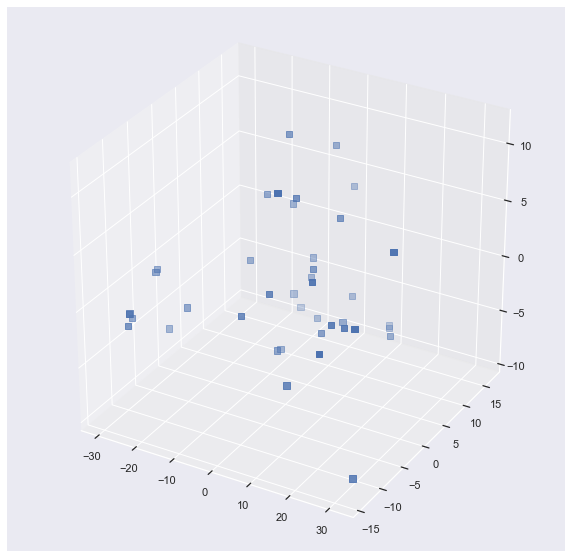

In [40]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
x = np.array(pca_transformed[:,0])
y = np.array(pca_transformed[:,1])
z = np.array(pca_transformed[:,2])

ax.scatter(x,y,z, marker="s",  s=40, cmap="RdBu")

plt.show();

In [41]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(pca_transformed)
cluster_kmeans = kmeans.predict(pca_transformed)

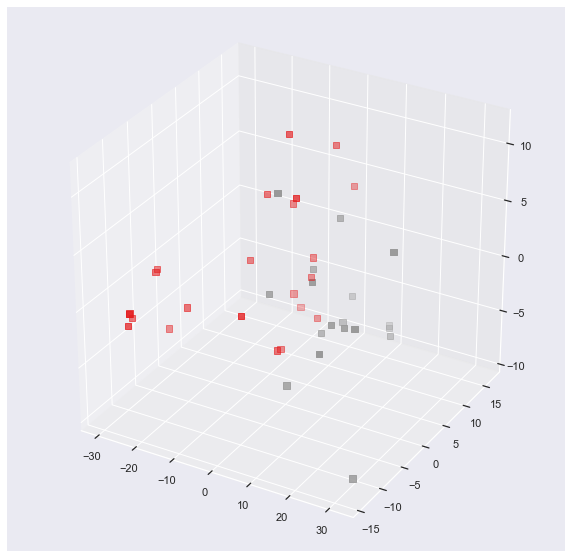

In [42]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
x = np.array(pca_transformed[:,0])
y = np.array(pca_transformed[:,1])
z = np.array(pca_transformed[:,2])

ax.scatter(x,y,z, c=cluster_kmeans, marker="s", s=40, cmap = 'Set1')

plt.show();

In [43]:
case_per_neighborhood['cluster'] = cluster_kmeans

In [44]:
cluser_0 = case_per_neighborhood[case_per_neighborhood['cluster'] == 0]

cluser_0

,borough,uhf34_neigh,uhf42_neigh,population,positive_rate,test_per_capita,obesity_percent,excercise_percent,copd_rate,smoking_percent,drinking_percent,cluster
0,Queens,Bayside Little Neck-Fresh Meadows,Bayside - Little Neck,87423,35.44,0.040,53.4,73.4,14.4,11.2,11.7,0
1,Queens,Bayside Little Neck-Fresh Meadows,Fresh Meadows,95537,39.06,0.055,53.4,73.4,14.5,11.2,11.7,0
4,Brooklyn,Borough Park,Borough Park,322563,38.58,0.065,56.3,65.2,16.9,9.8,9.5,0
5,Brooklyn,Canarsie - Flatlands,Canarsie-Flatlands,191734,43.48,0.060,61.3,69.0,15.1,10.6,7.0,0
6,Manhattan,Central Harlem - Morningside Heights,Central Harlem - Morningside Heights,162238,35.05,0.050,52.4,73.2,29.6,17.2,27.1,0
7,Manhattan,Chelsea-Village,Chelsea-Clinton,143506,29.83,0.045,36.7,82.8,15.0,11.2,33.9,0
8,Manhattan,Chelsea-Village,Greenwich Village - Soho,83664,27.32,0.029,36.7,82.8,15.8,11.2,33.9,0
10,Brooklyn,Downtown - Heights - Slope,Downtown-Heights -Slope,227057,30.64,0.039,44.2,82.6,14.2,11.8,26.6,0
11,Brooklyn,East Flatbush - Flatbush,East Flatbush - Flatbush,309120,42.60,0.049,63.6,77.5,19.9,10.4,15.2,0
14,Queens,Flushing - Clearview,Flushing - Clearview,260468,40.76,0.040,48.7,75.9,14.5,18.4,12.3,0


In [45]:
cluster_0_means = np.mean(cluser_0)

cluster_0_means

population           201039.083333
positive_rate            36.153750
test_per_capita           0.046750
obesity_percent          50.404167
excercise_percent        77.604167
copd_rate                15.816667
smoking_percent          12.100000
drinking_percent         20.087500
cluster                   0.000000
dtype: float64

In [46]:
cluser_1 = case_per_neighborhood[case_per_neighborhood['cluster'] == 1]

cluser_1

,borough,uhf34_neigh,uhf42_neigh,population,positive_rate,test_per_capita,obesity_percent,excercise_percent,copd_rate,smoking_percent,drinking_percent,cluster
2,Brooklyn,Bedford Stuyvesant - Crown Heights,Bedford Stuyvesant - Crown Heights,316269,39.09,0.044,67.2,71.4,27.7,18.9,16.6,1
3,Brooklyn,Bensonhurst - Bay Ridge,Bensonhurst - Bay Ridge,201541,37.38,0.040,50.3,69.5,38.3,11.7,15.4,1
9,Brooklyn,Coney Island - Sheepshead Bay,Coney Island-Sheepshead Bay,285275,39.62,0.052,60.6,67.6,29.1,15.6,11.8,1
12,Manhattan,East Harlem,East Harlem,113291,40.11,0.055,62.0,80.8,40.3,18.2,19.1,1
13,Brooklyn,East New York,East New York,191151,42.49,0.049,66.7,73.1,46.0,17.1,13.9,1
15,Bronx,Fordham - Bronx Pk,Fordham - Bronx Pk,250249,43.39,0.066,65.1,70.9,45.5,11.0,17.7,1
17,Queens,Jamaica,Jamaica,292571,44.10,0.066,67.5,71.4,22.1,11.4,14.1,1
18,Bronx,Kingsbridge - Riverdale,Kingsbridge - Riverdale,94095,36.56,0.067,54.7,76.9,33.8,14.0,18.1,1
20,Bronx,Northeast Bronx,Northeast Bronx,190315,41.99,0.087,69.4,63.0,52.1,10.5,10.9,1
21,Staten Island,Northern SI,Port Richmond,70403,38.92,0.076,64.6,71.1,50.5,19.2,20.3,1


In [47]:
cluster_1_means = np.mean(cluser_1)

cluster_1_means

population           187300.500000
positive_rate            39.990556
test_per_capita           0.065333
obesity_percent          65.627778
excercise_percent        71.316667
copd_rate                37.394444
smoking_percent          16.416667
drinking_percent         15.888889
cluster                   1.000000
dtype: float64

In [48]:
cluster_means = pd.concat([cluster_0_means,cluster_1_means], axis = 1)
cluster_means

,0,1
population,201039.083333,187300.500000
positive_rate,36.153750,39.990556
test_per_capita,0.046750,0.065333
obesity_percent,50.404167,65.627778
excercise_percent,77.604167,71.316667
copd_rate,15.816667,37.394444
smoking_percent,12.100000,16.416667
drinking_percent,20.087500,15.888889
cluster,0.000000,1.000000


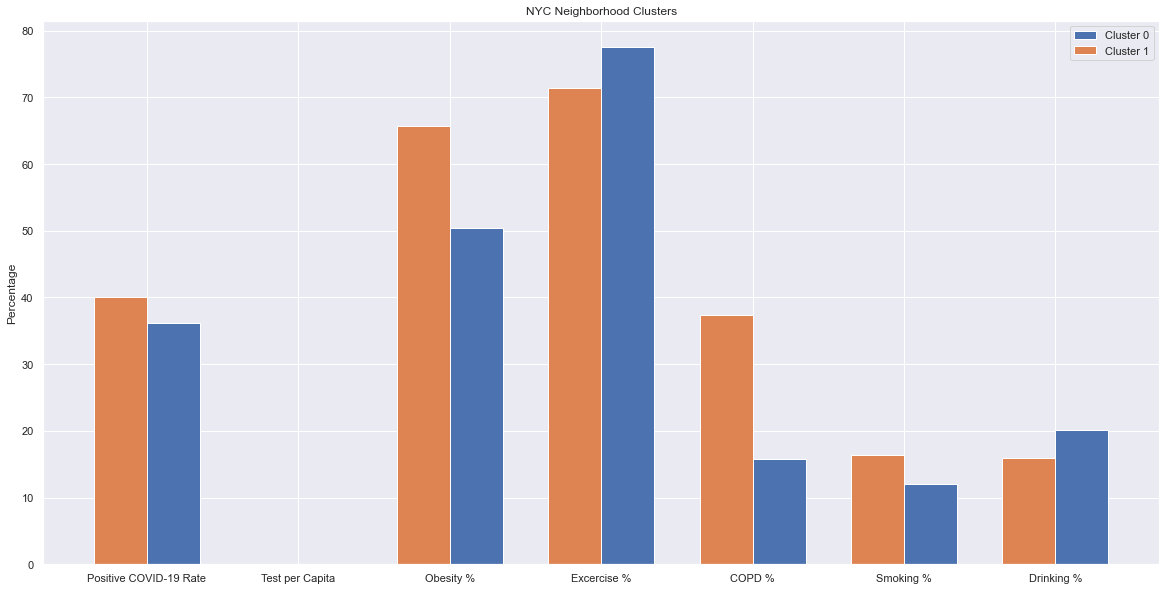

In [49]:
labels = ['Positive COVID-19 Rate', 'Test per Capita', 'Obesity %',
          'Excercise %', 'COPD %', 'Smoking %', 'Drinking %']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10))
rects1 = ax.bar(x + width/2, cluster_means.iloc[1:-1,0], width, label='Cluster 0')
rects2 = ax.bar(x - width/2, cluster_means.iloc[1:-1,1], width, label='Cluster 1')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('NYC Neighborhood Clusters')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [50]:
case_per_MODZCTA = test_by_zip.merge(case_per_neighborhood, left_on = 'uhf42_neigh', right_on = 'uhf42_neigh')

case_per_MODZCTA.head()

,MODZCTA,Positive,Total,zcta_cum.perc_pos,uhf34_neigh_x,uhf42_neigh,borough,uhf34_neigh_y,population,positive_rate,test_per_capita,obesity_percent,excercise_percent,copd_rate,smoking_percent,drinking_percent,cluster
0,10001,321,1130,28.41,Chelsea-Village,Chelsea-Clinton,Manhattan,Chelsea-Village,143506,29.83,0.045,36.7,82.8,15.0,11.2,33.9,0
1,10011,478,1606,29.76,Chelsea-Village,Chelsea-Clinton,Manhattan,Chelsea-Village,143506,29.83,0.045,36.7,82.8,15.0,11.2,33.9,0
2,10018,196,626,31.31,Chelsea-Village,Chelsea-Clinton,Manhattan,Chelsea-Village,143506,29.83,0.045,36.7,82.8,15.0,11.2,33.9,0
3,10019,547,1832,29.86,Chelsea-Village,Chelsea-Clinton,Manhattan,Chelsea-Village,143506,29.83,0.045,36.7,82.8,15.0,11.2,33.9,0
4,10036,377,1240,30.40,Chelsea-Village,Chelsea-Clinton,Manhattan,Chelsea-Village,143506,29.83,0.045,36.7,82.8,15.0,11.2,33.9,0


In [51]:
nyc_map = gpd.read_file('data/Geography-resources/MODZCTA_2010_WGS1984.geo.json')

nyc_map = nyc_map.merge(case_per_MODZCTA, left_on = 'MODZCTA', right_on = 'MODZCTA')

In [53]:
#Tranformign Pandas DF back to GeoDF

crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(nyc_map, crs=crs, geometry=nyc_map['geometry'])

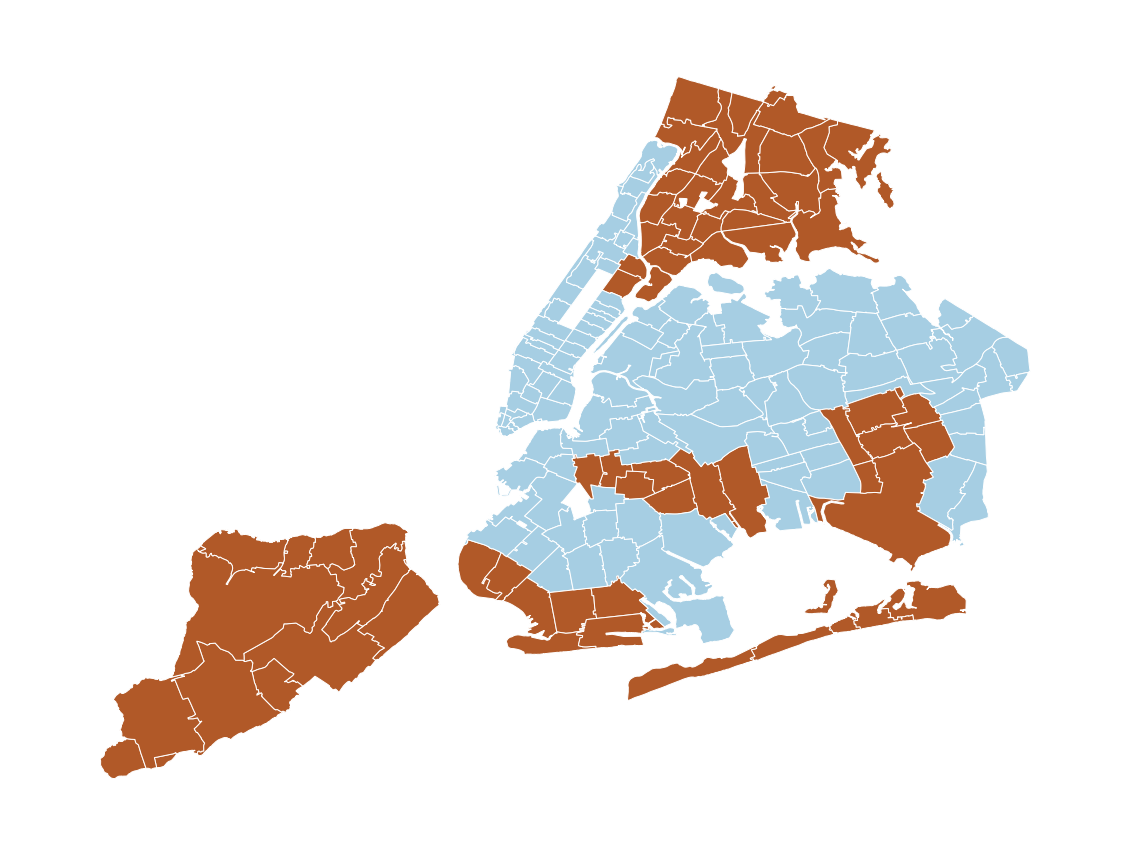

In [54]:
geoplot.choropleth(gdf, hue=gdf['cluster'], cmap='Paired',figsize=(20, 20))

plt.show()